## Import library

In [16]:
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

## MongoDB to DataFrame

In [3]:
# Mongodb 불러오기
import pymongo

# mongodb 연결
conn = pymongo.MongoClient()

# DB접근
db = conn['crawling_review']

# collection 접근
collection = db['movies']

In [4]:
# DataFrame
doc = collection.find_one()
data = pd.DataFrame(doc, columns=['star','comment'])
data.sample(10)

,star,comment
5014,1,소위 특급배우가 주차장 없는 곳에 자택이 있고 편의점에 주차하고 귀가하다 납치 당하...
2993,6,
6536,8,박정민 배우가 최소 제작비 절반은 투자한 듯. 박정민 배우가 아무리 매력있어도 윤아...
9768,10,진정한 속편이다…ㅎpc가득한 전편은 쓰레기통으로~~~이언 역할한 해롤드가 세상을 ...
4161,8,외로움에 관한 이야기에서 성공한 하나의 자아로 변신
8064,6,왜가 많이 부족한 영화네 도대체 장혁이 저러는 이유가 뭐냐
4412,7,화보의 연속 자막에 쫓기느라 음미가 안 되는 게 문제 븅된 기분
9589,10,
317,8,디즈니는 역시디즈니 음악도좋고 미소가떠나지않네요
3111,6,"그냥 킬링타임용 수준, 장혁 말투가 영화 내내 거슬림."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   star     9990 non-null   object
 1   comment  9990 non-null   object
dtypes: object(2)
memory usage: 156.2+ KB


In [6]:
# data tpye 변경
data = data.astype({'star':'int'})
data.dtypes

star        int32
comment    object
dtype: object

## label 설정

In [7]:
# 평점 7 이상 = 긍정(1)
data_pos = data[data['star']>=7]
data_pos['label'] = 1
data_pos

C:\Users\User\AppData\Local\Temp/ipykernel_612/2313997164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['label'] = 1


,star,comment,label
0,10,평점이 낮아서 안보려다 봤는데 보길 정말 잘했슴ㄷㅏ.저는 지루하지않았고 후반부로 갈...,1
1,10,가슴 시리도록 기억에 오래 남을 영화. 공유 전도연의 연기는.. 잊혀지지 않을 것 ...,1
3,9,우리가 자라고 우리가 사랑을 하고 우리가 결혼을 하고 우리가 아이를 키우고 우리가 ...,1
5,7,믿고보는 황정밋 배우!!,1
8,10,으악 ㅋㅋ 너무무서웠어요 ㅠㅠ,1
...,...,...,...
9981,10,굿굿 ㅅ평점왜이러지?,1
9983,10,참신한 주제와 훌륭한 배우들과 연출 좋았습니다 몰입해서 잘 봤어요,1
9986,7,로맨스 영화를 가장한 SF물이라서 뭔가 아쉬움이 남는 영화.개봉당시 포스터만 봐도 ...,1
9987,10,"연출, 연기 다 좋습니다",1


In [8]:
# 평점 6 이하 = 부정(0)
data_neg = data[data['star']<7]
data_neg['label'] = 0
data_neg

C:\Users\User\AppData\Local\Temp/ipykernel_612/1242165523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['label'] = 0


,star,comment,label
2,1,대체... 이게 뭐죠?,0
4,1,보는 내가 유체이탈할뻔 보다가 나온 영화는 처음임답답하고 주인공 본인도 몰라 답답한...,0
6,1,고양이가 그렇게 불쌍하시면 데려가서 키우세요. 집없이 밖에서 벌벌떠는 고양이들이 불...,0
7,2,연출 연기 스토리 전부 잘못된 영화,0
9,1,중국 자본인 게 너무 티나서 아쉽다.,0
...,...,...,...
9980,5,재미없음,0
9982,3,"필름을 드라마 찍을때 사용하는 방식으로 찍엇노??? 장혁,유오성 너무 아깝다. 감독...",0
9984,4,강원도사투리가 넘쎄서 영화스타일이랑 안어울림. 뭐라고하는지 원...,0
9985,6,님의 하드캐리,0


In [9]:
# 데이터 합치고 필요없는 column 제거
df = pd.concat([data_pos,data_neg], ignore_index=True)
df.sample(10)

,star,comment,label
7254,4,마블 영화 최악중 탑3..,0
1588,10,오랜만에 보는 중세시대 영화네요.같은 사건을 3명의 시각에서 보는 연출이 참 좋았고...,1
7432,4,이상한 아줌마 하나 때문에 여러명 죽어나가는중..,0
8237,1,좋은 배우분들은 잘못이 없습니다. 재밌는 로맨스물을 기대했는데... 개연성이 제로 ...,0
7399,6,장르에 비해 딱딱한 이야기 흐름과 애매한 엔딩...,0
2292,10,"아무정보 없이 영화보러 가서 스릴러라 무서울까봐 망설였는데, 정말 몰입도도 높고 내...",1
9475,2,잠깐만...귀신이 나오긴 하는데...기억에 남는 귀신이....먹깨비 하나...?아니...,0
5948,10,경치 좋은 곳에서 여유있게 따뜻한 차한잔을 마신 느낌. 맑고 상쾌합니다.,1
3655,10,신파라함은 억지로 눈물샘 자극하는건데 이 영화는 스토리자체가 슬픈거라 전혀 신파라 ...,1
7632,1,좋은 영화를 마지막편으로 만든느낌 감독님 그냥 배우나 하셔,0


1    6924
0    3066
Name: label, dtype: int64


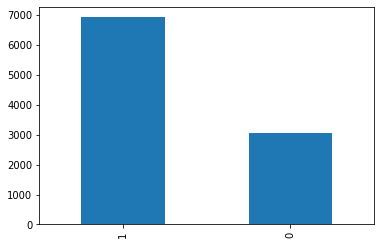

In [10]:
# label 비율 확인, 불균형은 SMOTE로 해겷기
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

## Preprocessing

In [11]:
# NA 확인
df.isna().sum()

star       0
comment    0
label      0
dtype: int64

In [12]:
# comment가 없는 경우 제외
df = df[df['comment']!='']
df.sample(10)

,star,comment,label
7250,1,중뽕에다 동북공정까지 자행하는 최악의 영화. 액션이 전부 그래픽에다 주연들은 솔직히...,0
7149,6,킬링 타임용 오락 영화임,0
8836,6,그 시절의 청춘 스타들이 총출동한 코폴라 감독의 범작. 60년대 배경의 잘 사는 윗...,0
5925,10,"임금의 곤룡포와, 양반들의 비단옷과, 백성들의 낡은 옷을 모두 흑백처리함으로써, 만...",1
1246,10,남녀 로맨스물인지 알고 봤는데 자연과 인간의 관계를 남녀의 연애감정에 빗대어 풀어 ...,1
6419,8,여기 평점들보고 나만 따라가기 힘든게 아니었구나싶어 위안을 얻고갑니다 그래도 웨스앤...,1
2480,10,이게 실화라니... 명작이다,1
1074,10,첫 개봉당시 군인이어서 영화관에서 못봤었는데 드디어 이영화를 영화관에서 관람함ㅠㅠ ...,1
1544,10,"간만에 정말 재밌게 본 신박한 로코물!전종서 배우님, 손석구 배우님 모두 매력 철철",1
7803,5,배우분들때문에 기대했지만...,0


In [14]:
# 한글,공백 제외하고 제거
df['comment'] = df['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.sample(5)

C:\Users\User\AppData\Local\Temp/ipykernel_612/2958532500.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,star,comment,label
456,10,스토리 전개가 잔잔한 영화도 지루하지 않고 얼마든지 재미있다는 걸 알게 해준 영화입니다,1
4406,9,편 보고 꼭 가세요,1
1971,7,지금까지의 마블과 비교해서 신선함은 없었음,1
7823,2,요샌 도시 이름을 딴 간단명료한 제목이 유행인가요 수퍼히어로물을 현실로 재현한듯 합...,0
5983,10,재미있고 안 보면 후회함ㅋㅋㅋ,1


### Stopword

In [15]:
# https://www.ranks.nl/stopwords/korean
stopword = pd.read_csv('stopword.csv')
stopword = list(stopword['stopdword'].values)
print(stopword[:5])

['아', '휴', '아이구', '아이쿠', '아이고']


In [27]:
# 한국어 형태소 분석기
okt = Okt()

JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.